<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/Revised_NN_predict_v20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [156]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time, joblib, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os.path
import tensorflow

from sklearn.metrics import r2_score
from scipy import stats
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import scipy.stats as st
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [64]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [65]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Get working_df

## Find cutoff index

In [66]:
def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

In [67]:
# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

In [68]:
def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  #agg_df = aggreagator_v2(df)
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [69]:
def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

## Select working data

In [70]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  working_df = pd.merge(extra_info_df, data_df, left_index=True, right_index=True)
  return working_df

In [163]:
def main_cutoff(input_path, manual_cutoff=(False, 0.05)):
  print('Reading data from file...')

  data = io.BytesIO(open(input_path, 'rb').read())
  df = pd.read_excel(data, sheet_name='Sheet1', skiprows=1)
  print('Cleaning data...')
  #df.iloc[0].fillna(method='bfill', inplace=True)
  #df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)

  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  df = df.dropna() # remove nan rows

  if manual_cutoff[0] == False:
    cut_point = cut_off_idx(df)
  else:
    #df = aggreagator_v2(df)
    amt_col = df.shape[1]
    m_cutoff_lower = int(amt_col*manual_cutoff[1])
    m_cutoff_upper = int(amt_col-(amt_col*manual_cutoff[1]))
    cut_point = (m_cutoff_lower, m_cutoff_upper)
  working_df = select_working_data(df, cut_point)

  return working_df

## Run main cutoff

In [168]:
'''
input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"

working_df = main_cutoff(input_path, manual_cutoff=(True, 0.1))
working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)
display(working_df)
'''

Reading data from file...
Cleaning data...


,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-32,-31.96875,-31.9375,-31.90625,...,31.875,31.90625,31.9375,31.96875,32,32.03125,32.0625,32.09375,32.125,32.15625
10,11,1,1,880,0,11,-4.288411,-3.866353,-8.848130,-4.040455,...,-45.552842,-48.710120,-40.455435,-39.471511,-46.199010,-38.975500,-44.621381,-41.036712,-39.731308,-47.848074
11,12,1,1,960,0,12,-4.313618,-3.805286,-8.717380,-4.020294,...,-57.273952,-43.979164,-40.902213,-37.723594,-42.126039,-41.831460,-48.702392,-40.710516,-39.620562,-41.943514
12,13,1,1,1040,0,13,-4.386294,-3.844987,-8.714265,-4.047580,...,-44.205376,-43.300426,-44.166760,-37.847274,-42.042657,-44.773968,-58.640607,-43.571113,-40.165815,-39.548374
13,14,1,1,1120,0,14,-4.345850,-3.815269,-8.769979,-4.074033,...,-43.279405,-41.611440,-41.096216,-40.228315,-43.807593,-53.669545,-43.850225,-46.754092,-40.471985,-41.334720
14,15,1,1,1200,0,15,-4.259259,-3.782323,-8.739724,-3.961914,...,-39.606800,-53.647691,-39.069100,-37.870635,-39.188813,-41.754194,-55.710532,-41.542482,-51.266749,-41.266649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,326,14,1,80,0,1,-7.865521,-8.608569,-21.470186,-8.017949,...,-56.845026,-75.384181,-60.917859,-53.688049,-62.125147,-58.475953,-56.330811,-57.658670,-53.354919,-53.249599
326,327,14,1,160,0,2,-7.882314,-8.567324,-21.253700,-8.030925,...,-45.195908,-51.739517,-43.350686,-49.316534,-60.500550,-49.901082,-48.216711,-42.867324,-45.515882,-50.622444
327,328,14,1,240,0,3,-7.973839,-8.587559,-21.390277,-8.072506,...,-49.165181,-40.187150,-40.143274,-46.927057,-48.104041,-59.518351,-53.018747,-38.980716,-38.870960,-43.525852
328,329,14,1,320,0,4,-7.883212,-8.489211,-21.354756,-8.033088,...,-46.120927,-45.693955,-39.094330,-47.674141,-41.369390,-58.507058,-58.631208,-36.862701,-40.935300,-39.689240


# Bootstrapping

## Get max and min values of each column

In [73]:
def get_max_min_val_col(working_df):
  distances = [x*80 for x in range(1, 26)]
  data_working_df = working_df.iloc[:, 6:working_df.shape[1]]
  h_list = list(data_working_df.columns.values)
  max_min_col_dict = {header:[] for header in h_list}

  for d in tqdm(distances):
    boot_dist_df = working_df.loc[working_df['Distance_km'] == d]
    for idx in range(6, boot_dist_df.shape[1]):
      max_val_col = float(boot_dist_df.iloc[:, [idx]].quantile(0.1)) # max val in col
      min_val_col = float(boot_dist_df.iloc[:, [idx]].quantile(0.9)) # min val in col
      h = boot_dist_df.iloc[:, [idx]].columns # header of col
      h = h[0]
      max_min_col_dict[h].append((d, min_val_col, max_val_col))
  return max_min_col_dict

## Create new samples using bootstrap technique

In [176]:
#def create_bootstrap_samples(working_df, max_min_col_dict, target_amt_of_samples=100):
def create_bootstrap_samples(working_df, target_amt_of_samples=100):
  import random
  row_data = []
  PBRS_id_data = []
  Distance_km_data = []
  power_dBm_data = []
  span_data = []
  
  distances = [x*80 for x in range(1, 26)]

  h_list = list(working_df.columns.values)
  new_data = {header:[] for header in h_list}

  extra_h = ['row', 'PBRS_id', 'Channels', 'Distance_km', 'power_dBm', '#span']
  for i in extra_h:
    h_list.remove(i)

  last_row_in_old_df_val = working_df.shape[0] + 1
  #for new_sample in tqdm(range(num_of_new_samples)): # generating (num_of_new_samples) new samples for en data
  for d in tqdm(distances):
    current_distance_samples = working_df.loc[working_df['Distance_km'] == d]

    for new_sample_cnt in range(1, target_amt_of_samples+1):
      filtered_values = np.where((working_df['PBRS_id']==new_sample_cnt) & (working_df['Distance_km']== d))
      if len(filtered_values[0]) == 0: # check if do not have already a value present
        new_data['row'].append(last_row_in_old_df_val)
        last_row_in_old_df_val += 1
        new_data['PBRS_id'].append(new_sample_cnt)

        new_data['Channels'].append(1)
        new_data['Distance_km'].append(d)
        new_data['power_dBm'].append(0)
        new_data['#span'].append(int(d/80))

        for h in h_list:
          vals_list = current_distance_samples[str(h)].tolist()
          random_val = random.choice(vals_list)
          new_data[str(h)].append(random_val)

        '''
        for k, v in max_min_col_dict.items(): # header:(d, min_val_col, max_val_col)
          for val in v:
            if val[0] == d:
              bootstrap_val = round(random.uniform(val[1], val[2]), 14)
              new_data[str(k)].append(bootstrap_val)
              break
        '''
  new_data_df = pd.DataFrame.from_dict(new_data)

  return new_data_df

## Combine previous df with bootstraped df

In [177]:
'''
input_path = path + "/Spectrum/NN/new_data_working_df.csv"
working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

#print('Get max min for each distance...')
#max_min_col_dict = get_max_min_val_col(working_df)
                                       
print('Creating new samples...')
new_data_df = create_bootstrap_samples(working_df, target_amt_of_samples=100)
new_working_df = working_df.append(new_data_df)
new_working_df = new_working_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

new_working_df.to_csv(path + "/Spectrum/NN/bootstraped_new_data_working_df.csv", index=False)
new_working_df
'''

Creating new samples...


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-32,-31.96875,-31.9375,-31.90625,...,31.875,31.90625,31.9375,31.96875,32,32.03125,32.0625,32.09375,32.125,32.15625
0,301,1,1,80,0,1,-10.491669,-24.788990,-7.865921,-7.972531,...,-60.096647,-54.754780,-60.917859,-63.596330,-54.160554,-67.065394,-65.198398,-57.658670,-61.611164,-62.354193
88,389,1,1,160,0,2,-7.745044,-14.361110,-9.221630,-11.181389,...,-50.127708,-47.564960,-46.887077,-40.883270,-49.155230,-38.403549,-48.216711,-40.447349,-45.515882,-57.134960
176,477,1,1,240,0,3,-5.798784,-8.587559,-15.381452,-3.910673,...,-41.367358,-40.952325,-47.774484,-47.918782,-41.011285,-44.523754,-47.367608,-41.399499,-56.211731,-36.626820
264,565,1,1,320,0,4,-11.855434,-24.398515,-21.354756,-20.377997,...,-42.132182,-42.759255,-42.213528,-43.249978,-47.998506,-44.084004,-45.288930,-49.211730,-43.624331,-40.000700
352,653,1,1,400,0,5,-14.607697,-24.523284,-11.300845,-8.128802,...,-42.816171,-37.794891,-39.495485,-41.503243,-46.590446,-37.250253,-47.256079,-48.911049,-45.298517,-36.835328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,2148,100,1,1680,0,21,-5.993146,-15.966866,-10.097579,-5.006026,...,-43.820937,-40.234703,-28.210701,-35.982701,-33.968972,-31.793775,-33.372435,-41.720079,-35.835164,-42.688574
1935,2236,100,1,1760,0,22,-7.186369,-9.142978,-18.714688,-5.932271,...,-42.447353,-41.772722,-38.644031,-45.130837,-33.348058,-49.057276,-31.979080,-31.047597,-35.219658,-33.284240
2023,2324,100,1,1840,0,23,-6.013048,-4.792800,-10.253523,-4.123721,...,-33.476343,-42.478623,-32.976384,-47.886963,-35.040083,-43.369900,-31.797359,-30.676750,-27.487513,-32.908134
2111,2412,100,1,1920,0,24,-12.564532,-14.617258,-10.019363,-6.783398,...,-44.083565,-45.197743,-34.114403,-31.805838,-36.240401,-28.887066,-30.719291,-47.546404,-35.628008,-34.095505


# New version train test split

## Freq filter

In [178]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, [0,1]]
  data_df = df.iloc[:, 1:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  for i in range(0, num_selected_freq):
    df2 = data_df.iloc[:, (i+1)*span_val].to_frame()
    if i+1 == 1:
      new_df = df2
    else:
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
  new_df = info_df.join(new_df)
  
  return new_df

def get_data(working_df, distances, num_features = 20, span_length=80, min_dist = 0, max_dist = 2000):
  X=None
  Y=np.array([])
  id_df = working_df.iloc[:, 1]
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]

  id_dist_df = pd.merge(id_df, dist_df, left_index=True, right_index=True)
  samples_df = pd.merge(id_dist_df, freq_df, left_index=True, right_index=True)

  if num_features != 'all':
    samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)
  Y = samples_df.iloc[:, 1].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 2:samples_df.shape[1]]
  
  return X, Y, samples_df

In [179]:
'''
distances = [x*80 for x in range(1, 26)]
X, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)
samples_filtered_df
'''

'\ndistances = [x*80 for x in range(1, 26)]\nX, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)\nsamples_filtered_df\n'

## Reference split

In [180]:
def get_reference_and_sample_data_split(samples_filtered_df, num_reference=30):
  import random
  num_of_ids = len(samples_filtered_df['PBRS_id'].unique())

  l = list(range(1, num_of_ids+1))
  random.shuffle(l)
  reference_arr = (l[:num_reference]) # selecting first "num_reference" random values
  sample_arr = l[-(num_of_ids-num_reference):]

  reference_data_df = samples_filtered_df[samples_filtered_df['PBRS_id'].isin(reference_arr)]
  sample_data_df = samples_filtered_df[samples_filtered_df['PBRS_id'].isin(sample_arr)]
  reference_data_df = reference_data_df.sort_values(by='PBRS_id')
  sample_data_df = sample_data_df.sort_values(by='PBRS_id')

  reference_data_df = reference_data_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])
  sample_data_df = sample_data_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

  return reference_data_df, sample_data_df

In [181]:
#reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=30)
#sample_freq_data_df

## features calc

In [182]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=False):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  if test_references_params[0] == True: # Test reference distance portion
    reference_freq_data_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == test_references_params[1]]

  for row_idx in tqdm(range(0, sample_freq_data_df.shape[0])):
    data_Y = sample_freq_data_df.iloc[row_idx,1] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,2:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data -----------------
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]
    if distance_reference_df.empty:
      distance_reference_df = reference_freq_data_df.copy()

    pearson_vals = []
    confidence_vals_lower = []
    confidence_vals_upper = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,2:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(round(abs(reference_confidence_int_lower - data_confidence_int_lower), 5))
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(round(abs(reference_confidence_int_upper - data_confidence_int_upper),5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(np.min(confidence_vals_lower))
    data_CI_upper.append(np.min(confidence_vals_upper))

  if ci == False:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max}
  else:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max,
                    'delta_CI_min':data_CI_lower,
                    'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)

  return data_df

In [183]:
'''
test_references_params=(False, [80, 1040, 2000])

features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params)
features_df
'''

'\ntest_references_params=(False, [80, 1040, 2000])\n\nfeatures_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params)\nfeatures_df\n'

## train_test split

In [204]:
def train_and_test_split_funct(features_df, test_size=0.2):
  x_train, x_test, y_train, y_test = train_test_split(features_df.values[:, 1:features_df.values.shape[1]], features_df.values[:, 0], test_size=test_size, random_state=111)

  scaler = MinMaxScaler()
  data_scaler = scaler.fit(x_train)
  
  x_train = data_scaler.transform(x_train)
  x_test = data_scaler.transform(x_test)
  
  joblib.dump(data_scaler, path+'/Spectrum/NN/revised_NNs/scaler_nn.joblib')

  return x_train, y_train, x_test, y_test, data_scaler

In [185]:
#x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=0.2)

## main features train_test

In [186]:
def main_features_train_test_split(input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)

    distances = [x*80 for x in range(1, 26)]
    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    
    reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df

In [187]:
'''
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=True, split_done=False)
'''

'\ninput_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"\n\nx_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(\n    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=True, split_done=False)\n'

#Test new data

## Neural Network

In [ ]:
def train_nn_model(x_train, y_train, x_test, y_test, nn_model, epochs, batch_size, params_callback=('loss', 200), monitor_model= False, verbose=0):
  if monitor_model == False:
    callback = tf.keras.callbacks.EarlyStopping(monitor=params_callback[0], patience=params_callback[1])
    history = nn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback], validation_split=0.1, verbose=verbose) # , callbacks=[early_stopping], 

    nn_model.save(path+"/Spectrum/NN/revised_NNs/NN_epochs_"+str(epochs)+".h5")
  else: 
    callback = tf.keras.callbacks.ModelCheckpoint(path+"/Spectrum/NN/revised_NNs/monitor_best_NN_epochs_"+str(epochs)+".h5", monitor='loss', verbose=0, save_best_only=True)
    history = nn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback], shuffle=True, validation_data=(x_test, y_test), verbose=verbose) # , callbacks=[early_stopping], 

  return history, nn_model

In [ ]:
def build_model(input_size, layer_units, summary=False):
  x = tensorflow.keras.layers.Input(shape=(input_size,), name="nn_input")

  dense_layer1 = tensorflow.keras.layers.Dense(units=layer_units[0], activation='tanh', name="dense_1")(x)
  dense_layer2 = tensorflow.keras.layers.Dense(units=layer_units[1], activation='tanh', name="dense_2")(dense_layer1)
  dense_layer3 = tensorflow.keras.layers.Dense(units=layer_units[2], activation='tanh', name="dense_3")(dense_layer2)
  dense_layer4 = tensorflow.keras.layers.Dense(units=layer_units[3], activation='tanh', name="dense_4")(dense_layer3)
  dense_layer5 = tensorflow.keras.layers.Dense(units=layer_units[4], activation='tanh', name="dense_5")(dense_layer4)
  nn_output = tensorflow.keras.layers.Dense(units=layer_units[5], name="nn_output")(dense_layer5)

  nn_model = tensorflow.keras.models.Model(x, nn_output, name="nn_model")
  nn_model.compile(optimizer=tensorflow.keras.optimizers.RMSprop(), loss=tensorflow.keras.losses.MeanAbsoluteError())
  if summary == True:
    nn_model.summary()

  return nn_model

##Fail

In [ ]:
# Import all needed libraries and sublibraries

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt

In [ ]:
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

ci = False # include or exclude CI calc

parameters_freq_reference = (20, 30) #(num_frequencies, num_references)
x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=ci, split_done=False)


# inverted_x_test = scaler.inverse_transform(x_test)

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


100%|██████████| 1750/1750 [01:04<00:00, 27.33it/s]



Obtaining train and test split...
Done


------------------Trainig lr------------------
Epoch 942: early stopping
The R2 score on the Train set is:	-0.000
The R2 score on the Test set is:	-0.000


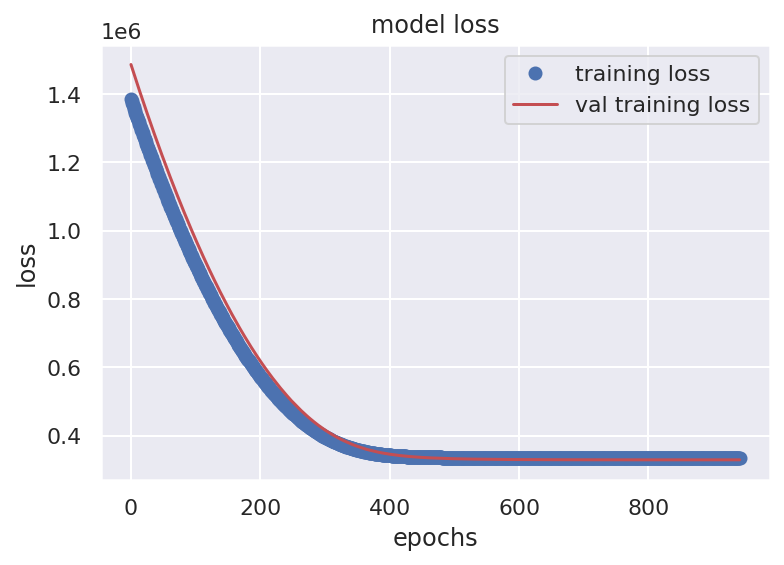

In [ ]:
if ci == False:
  input_size = 5
else:
  input_size = 7

#Defines linear regression model and its structure
model = Sequential()
model.add(Dense(76, input_shape=(input_size,), activation='tanh'))
model.add(Dense(38, activation='tanh'))
model.add(Dense(19, activation='tanh'))
model.add(Dense(1,))

#Compiles model
opt = tf.keras.optimizers.RMSprop()
model.compile(opt, 'mean_squared_error')

#Fits model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
print('------------------Trainig------------------')
history = model.fit(x_train, y_train, epochs = 1000, validation_split = 0.2, batch_size=8, callbacks = [earlystop], shuffle = True, verbose = 0)
history_dict=history.history

#Plots model's training cost/loss and model's validation split cost/loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure()
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss', 'val training loss'], loc='best')

# Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
# with its current weights on the training and testing data
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

# train best than test overfitting

In [ ]:
df = pd.DataFrame(y_test, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 1040.0')

,actual,pred,error
9,1040.0,1030.578857,9.421143
26,1040.0,1030.578857,9.421143
56,1040.0,1030.578857,9.421143
61,1040.0,1030.578857,9.421143
86,1040.0,1030.578857,9.421143
136,1040.0,1030.578857,9.421143
153,1040.0,1030.578857,9.421143
165,1040.0,1030.578857,9.421143
188,1040.0,1030.578857,9.421143
286,1040.0,1030.578857,9.421143


## Test Run

In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 7, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  model.compile(loss ='mean_squared_error', optimizer = 'RMSprop')
  return model

def train_model(X_train, Y_train, num_of_freq_selected, reference_amt):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  print('Training model...')
  model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [ ]:
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

ci = True # include or exclude CI calc

parameters_freq_reference = (50, 30) #(num_frequencies, num_references)
x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=ci, split_done=False)


# inverted_x_test = scaler.inverse_transform(x_test)

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


100%|██████████| 1750/1750 [00:58<00:00, 29.88it/s]



Obtaining train and test split...
Done


Training model (freq_50_reference_30)...
Training model...
INFO:tensorflow:Assets written to: ram://9b42a18d-5187-4847-ba59-3a4b84318dbb/assets


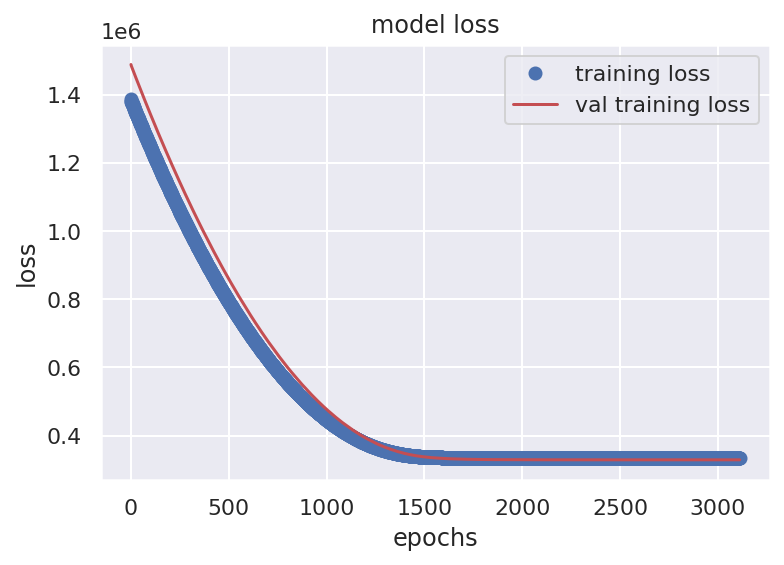

In [ ]:
model_ann = train_model(x_train, y_train, parameters_freq_reference[0], parameters_freq_reference[1])

In [ ]:
y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

df = pd.DataFrame(y_test, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 1040.0')

The R2 score on the Train set is:	-0.000
The R2 score on the Test set is:	-0.000


,actual,pred,error
9,1040.0,1030.781494,9.218506
26,1040.0,1030.781494,9.218506
56,1040.0,1030.781494,9.218506
61,1040.0,1030.781494,9.218506
86,1040.0,1030.781494,9.218506
136,1040.0,1030.781494,9.218506
153,1040.0,1030.781494,9.218506
165,1040.0,1030.781494,9.218506
188,1040.0,1030.781494,9.218506
286,1040.0,1030.781494,9.218506


## random search

In [193]:
!pip install keras-tuner -q

In [194]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras import optimizers

In [195]:
def build_model(hp):
    model = keras.Sequential()
    model.add(tf.keras.layers.Dense(hp.Int('units_0', min_value=9, max_value=512, step=32), input_dim = 7, activation="relu"))
    for i in range(1, hp.Int('num_layers', 1, 8)):
        model.add(
            tf.keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int('units_' + str(i), min_value=9, max_value=512, step=32),
                activation="relu"),
        )
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

In [196]:
import os.path 
for i in range(0, 20):
  tunner_path = path+"/Spectrum/NN/revised_NNs/tunner_search_"+str(i)
  isdir = os.path.isdir(tunner_path) 
  if isdir == False:
    dir_tunner = tunner_path
    break

tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=3,
    directory=dir_tunner,
    project_name='Dist predictor')

In [197]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 9, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [205]:
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

ci = True # include or exclude CI calc

parameters_freq_reference = (30, 10) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

# inverted_x_test = scaler.inverse_transform(x_test)

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


100%|██████████| 2250/2250 [00:40<00:00, 55.04it/s]



Obtaining train and test split...
Done


In [ ]:
print('Evaluating hyperparameters...')
tuner.search(x_train, y_train_norm,
             epochs=200,
             validation_data=(x_test, y_test_norm), verbose=0)
print('Done')

Evaluating hyperparameters...


In [ ]:
tuner.results_summary()

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(7))
best_model.summary()

## test model

In [ ]:
if ci == False:
  input_size = 5
else:
  input_size = 7

#Defines linear regression model and its structure
model = Sequential()
model.add(Dense(329, input_shape=(input_size,), activation='relu'))
model.add(Dense(361, activation='relu'))
model.add(Dense(329, activation='relu'))
model.add(Dense(489, activation='relu'))
model.add(Dense(457, activation='relu'))
model.add(Dense(41, activation='relu'))
model.add(Dense(1, activation='linear'))

#Compiles model
opt = tf.keras.optimizers.Adam(0.01)
model.compile(opt, 'mean_squared_error')

#Fits model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
print('------------------Trainig------------------')
history = model.fit(x_train, y_train_norm, epochs = 5000, validation_split = 0.2, batch_size=32, callbacks = [earlystop], shuffle = True, verbose = 0)
history_dict=history.history

#Plots model's training cost/loss and model's validation split cost/loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure()
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss', 'val training loss'], loc='best')

# Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
# with its current weights on the training and testing data
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

# train best than test overfitting

In [ ]:
y_test_pred_denorm = (y_test_pred * ((y_test.max()-y_test.min())+y_test.min())
y_test_denorm = (y_test_norm * ((y_test.max()-y_test.min())+y_test.min())

# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_denorm, columns=['actual'])
df.insert(1, 'pred', res_y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 80.0')

## predict old

In [ ]:
def predict_test(model_ann, X_test, Y_test, remove_outliers=5, params_freq_reference = (10, 30), all_plots=True, epochs_num=600, training_data=False):
  print('Results (freq_'+str(params_freq_reference[0])+'_reference_'+str(params_freq_reference[1])+')')
  # Predit
  start_time = time.time()
  Y_test_pred=model_ann.predict(X_test)
  pred=list(Y_test_pred)

  time_eval_ann=time.time()-start_time

  dist_min=80
  dist_max=2000

  real=list(Y_test)
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

  print('Real_abs:')
  print(real_abs)
  print('Pred_abs:')
  print(pred_abs)

  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  error_v2_Q1 = np.percentile(error_v2, remove_outliers, interpolation = 'midpoint')
  error_v2_Q3 = np.percentile(error_v2, 100-remove_outliers,interpolation = 'midpoint')
  error_v2_IQR = error_v2_Q3 - error_v2_Q1
  error_v2_lower = error_v2_Q1-1.5*error_v2_IQR
  error_v2_upper = error_v2_Q3+1.5*error_v2_IQR

  error_v2_filtered = []
  idx_cnt = 0
  idx_filtered = []
  for e in error_v2:
    if e>=error_v2_lower and e<=error_v2_upper:
      error_v2_filtered.append(e)
      idx_filtered.append(idx_cnt)
    idx_cnt += 1

  filtered_real_abs = [real_abs[i] for i in idx_filtered]
  filtered_pred_abs = [pred_abs[i] for i in idx_filtered]

  if all_plots == True:
    res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
    res.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)

    res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
    res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)
    
    plt.plot(real_abs,error,'bo')
    plt.xlabel('Distances') 
    plt.ylabel('Error') 
    plt.title("Results Curve (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
    plt.show()
    
    plt.plot(real_abs,error_v2,'bo')
    plt.xlabel('Distances') 
    plt.ylabel('Error') 
    plt.title("Results Deltas (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")

    # Filtered Outliers
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances') 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
    plt.show()
  else:
    res_v2=pd.DataFrame({"dist":filtered_real_abs,"pred":filtered_pred_abs,"error":error_v2_filtered})
    # Filtered Outliers
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances') 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    if training_data == False:
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")   
    else:
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")
    plt.show()

# Validation

In [ ]:
train_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_training_data_NN_freq_10_reference_30.csv")
test_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_testing_data_NN_freq_10_reference_30.csv")

reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_10_reference_30.csv")
sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_10_reference_30.csv")

with open(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_traininig_Rows_NN_freq_10_reference_30.pkl", 'rb') as f:
  rows_training = pickle.load(f)
with open(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_testing_Rows_NN_freq_10_reference_30.pkl", 'rb') as f:
  rows_testing = pickle.load(f) 

In [ ]:
# load best NN model
new_model = tf.keras.models.load_model(path+"/Spectrum/NN/revised_NNs/NN_epochs_2750.h5")
# Show the model architecture
#new_model.summary()
predictions = new_model.predict(x_test)
predictions.shape
#predict_test(nn_model, Y_test, X_test, remove_outliers=5, params_freq_reference = (10, 30), all_plots=False, epochs_num='test', training_data=False)

(350, 1)

In [ ]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features(sample_freq_data_df, reference_freq_data_df, selected_rows, test_references_params):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  if test_references_params[0] == True: # Test reference distance portion
    reference_freq_data_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == test_references_params[1]]

  for row_idx in tqdm(selected_rows):
    data_Y = sample_freq_data_df.iloc[row_idx,3] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,6:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data -----------------
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]
    if distance_reference_df.empty:
      distance_reference_df = reference_freq_data_df.copy()

    pearson_vals = []
    confidence_vals_lower = []
    confidence_vals_upper = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,6:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(round(abs(reference_confidence_int_lower - data_confidence_int_lower), 5))
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(round(abs(reference_confidence_int_upper - data_confidence_int_upper),5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(np.min(confidence_vals_lower))
    data_CI_upper.append(np.min(confidence_vals_upper))

  data = {'distance':data_distance,
                  'mean':data_mean,
                  'std':data_std,
                  'pearson_min':data_pearson_min,
                  'pearson_mean':data_pearson_mean,
                  'pearson_max':data_pearson_max,
                  'delta_CI_min':data_CI_lower,
                  'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)
  
  return data_df

100%|██████████| 2350/2350 [01:58<00:00, 19.83it/s]


Results (freq_10_reference_30)
Real_abs:
[480, 640, 720, 880, 1280, 1440, 400, 160, 960, 1600, 960, 2000, 1600, 80, 800, 1360, 1200, 640, 1360, 320, 1040, 2000, 1760, 160, 1120, 1280, 320, 1200, 800, 1120, 1360, 1520, 1280, 480, 1440, 320, 160, 560, 1840, 1360, 480, 320, 1680, 1360, 1280, 960, 480, 560, 1920, 1440, 1040, 240, 1520, 80, 1840, 880, 640, 480, 960, 1680, 1600, 720, 640, 160, 400, 1280, 1840, 1280, 960, 880, 400, 1920, 1440, 1040, 1920, 1600, 1200, 1760, 1360, 1280, 1360, 1760, 1920, 640, 400, 1120, 560, 1280, 2000, 640, 800, 720, 720, 1760, 1920, 1680, 1600, 1040, 800, 1120, 960, 1680, 720, 320, 560, 1200, 480, 1120, 240, 2000, 1520, 880, 640, 1440, 1520, 400, 80, 720, 1360, 320, 1680, 400, 800, 960, 480, 320, 1360, 1120, 400, 400, 1520, 480, 800, 1840, 640, 480, 1040, 240, 1520, 1920, 1520, 1600, 1040, 1360, 1680, 720, 720, 1040, 160, 160, 1120, 880, 1840, 2000, 640, 560, 1280, 320, 1680, 80, 1280, 1200, 2000, 1920, 800, 80, 880, 320, 560, 1520, 1760, 480, 1920, 1360, 200

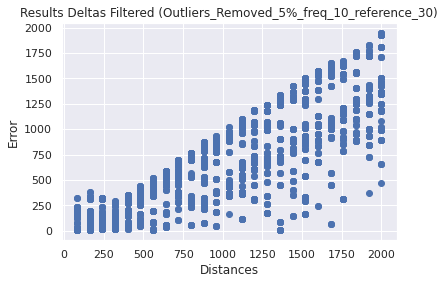

[0.20833333333333334, 0.2916666666666667, 0.3333333333333333, 0.4166666666666667, 0.625, 0.7083333333333334, 0.16666666666666666, 0.041666666666666664, 0.4583333333333333, 0.7916666666666666, 0.4583333333333333, 1.0, 0.7916666666666666, 0.0, 0.375, 0.6666666666666666, 0.5833333333333334, 0.2916666666666667, 0.6666666666666666, 0.125, 0.5, 1.0, 0.875, 0.041666666666666664, 0.5416666666666666, 0.625, 0.125, 0.5833333333333334, 0.375, 0.5416666666666666, 0.6666666666666666, 0.75, 0.625, 0.20833333333333334, 0.7083333333333334, 0.125, 0.041666666666666664, 0.25, 0.9166666666666666, 0.6666666666666666, 0.20833333333333334, 0.125, 0.8333333333333334, 0.6666666666666666, 0.625, 0.4583333333333333, 0.20833333333333334, 0.25, 0.9583333333333334, 0.7083333333333334, 0.5, 0.08333333333333333, 0.75, 0.0, 0.9166666666666666, 0.4166666666666667, 0.2916666666666667, 0.20833333333333334, 0.4583333333333333, 0.8333333333333334, 0.7916666666666666, 0.3333333333333333, 0.2916666666666667, 0.0416666666666

100%|██████████| 2350/2350 [01:50<00:00, 21.19it/s]


Results (freq_10_reference_30)
Real_abs:
[480, 640, 720, 880, 1280, 1440, 400, 160, 960, 1600, 960, 2000, 1600, 80, 800, 1360, 1200, 640, 1360, 320, 1040, 2000, 1760, 160, 1120, 1280, 320, 1200, 800, 1120, 1360, 1520, 1280, 480, 1440, 320, 160, 560, 1840, 1360, 480, 320, 1680, 1360, 1280, 960, 480, 560, 1920, 1440, 1040, 240, 1520, 80, 1840, 880, 640, 480, 960, 1680, 1600, 720, 640, 160, 400, 1280, 1840, 1280, 960, 880, 400, 1920, 1440, 1040, 1920, 1600, 1200, 1760, 1360, 1280, 1360, 1760, 1920, 640, 400, 1120, 560, 1280, 2000, 640, 800, 720, 720, 1760, 1920, 1680, 1600, 1040, 800, 1120, 960, 1680, 720, 320, 560, 1200, 480, 1120, 240, 2000, 1520, 880, 640, 1440, 1520, 400, 80, 720, 1360, 320, 1680, 400, 800, 960, 480, 320, 1360, 1120, 400, 400, 1520, 480, 800, 1840, 640, 480, 1040, 240, 1520, 1920, 1520, 1600, 1040, 1360, 1680, 720, 720, 1040, 160, 160, 1120, 880, 1840, 2000, 640, 560, 1280, 320, 1680, 80, 1280, 1200, 2000, 1920, 800, 80, 880, 320, 560, 1520, 1760, 480, 1920, 1360, 200

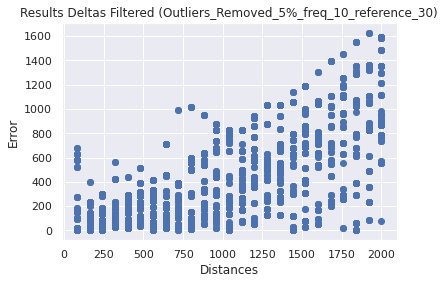

[0.20833333333333334, 0.2916666666666667, 0.3333333333333333, 0.4166666666666667, 0.625, 0.7083333333333334, 0.16666666666666666, 0.041666666666666664, 0.4583333333333333, 0.7916666666666666, 0.4583333333333333, 1.0, 0.7916666666666666, 0.0, 0.375, 0.6666666666666666, 0.5833333333333334, 0.2916666666666667, 0.6666666666666666, 0.125, 0.5, 1.0, 0.875, 0.041666666666666664, 0.5416666666666666, 0.625, 0.125, 0.5833333333333334, 0.375, 0.5416666666666666, 0.6666666666666666, 0.75, 0.625, 0.20833333333333334, 0.7083333333333334, 0.125, 0.041666666666666664, 0.25, 0.9166666666666666, 0.6666666666666666, 0.20833333333333334, 0.125, 0.8333333333333334, 0.6666666666666666, 0.625, 0.4583333333333333, 0.20833333333333334, 0.25, 0.9583333333333334, 0.7083333333333334, 0.5, 0.08333333333333333, 0.75, 0.0, 0.9166666666666666, 0.4166666666666667, 0.2916666666666667, 0.20833333333333334, 0.4583333333333333, 0.8333333333333334, 0.7916666666666666, 0.3333333333333333, 0.2916666666666667, 0.0416666666666

100%|██████████| 2350/2350 [01:47<00:00, 21.79it/s]


Results (freq_10_reference_30)
Real_abs:
[480, 640, 720, 880, 1280, 1440, 400, 160, 960, 1600, 960, 2000, 1600, 80, 800, 1360, 1200, 640, 1360, 320, 1040, 2000, 1760, 160, 1120, 1280, 320, 1200, 800, 1120, 1360, 1520, 1280, 480, 1440, 320, 160, 560, 1840, 1360, 480, 320, 1680, 1360, 1280, 960, 480, 560, 1920, 1440, 1040, 240, 1520, 80, 1840, 880, 640, 480, 960, 1680, 1600, 720, 640, 160, 400, 1280, 1840, 1280, 960, 880, 400, 1920, 1440, 1040, 1920, 1600, 1200, 1760, 1360, 1280, 1360, 1760, 1920, 640, 400, 1120, 560, 1280, 2000, 640, 800, 720, 720, 1760, 1920, 1680, 1600, 1040, 800, 1120, 960, 1680, 720, 320, 560, 1200, 480, 1120, 240, 2000, 1520, 880, 640, 1440, 1520, 400, 80, 720, 1360, 320, 1680, 400, 800, 960, 480, 320, 1360, 1120, 400, 400, 1520, 480, 800, 1840, 640, 480, 1040, 240, 1520, 1920, 1520, 1600, 1040, 1360, 1680, 720, 720, 1040, 160, 160, 1120, 880, 1840, 2000, 640, 560, 1280, 320, 1680, 80, 1280, 1200, 2000, 1920, 800, 80, 880, 320, 560, 1520, 1760, 480, 1920, 1360, 200

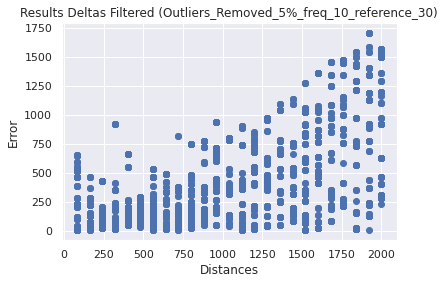

[0.20833333333333334, 0.2916666666666667, 0.3333333333333333, 0.4166666666666667, 0.625, 0.7083333333333334, 0.16666666666666666, 0.041666666666666664, 0.4583333333333333, 0.7916666666666666, 0.4583333333333333, 1.0, 0.7916666666666666, 0.0, 0.375, 0.6666666666666666, 0.5833333333333334, 0.2916666666666667, 0.6666666666666666, 0.125, 0.5, 1.0, 0.875, 0.041666666666666664, 0.5416666666666666, 0.625, 0.125, 0.5833333333333334, 0.375, 0.5416666666666666, 0.6666666666666666, 0.75, 0.625, 0.20833333333333334, 0.7083333333333334, 0.125, 0.041666666666666664, 0.25, 0.9166666666666666, 0.6666666666666666, 0.20833333333333334, 0.125, 0.8333333333333334, 0.6666666666666666, 0.625, 0.4583333333333333, 0.20833333333333334, 0.25, 0.9583333333333334, 0.7083333333333334, 0.5, 0.08333333333333333, 0.75, 0.0, 0.9166666666666666, 0.4166666666666667, 0.2916666666666667, 0.20833333333333334, 0.4583333333333333, 0.8333333333333334, 0.7916666666666666, 0.3333333333333333, 0.2916666666666667, 0.0416666666666

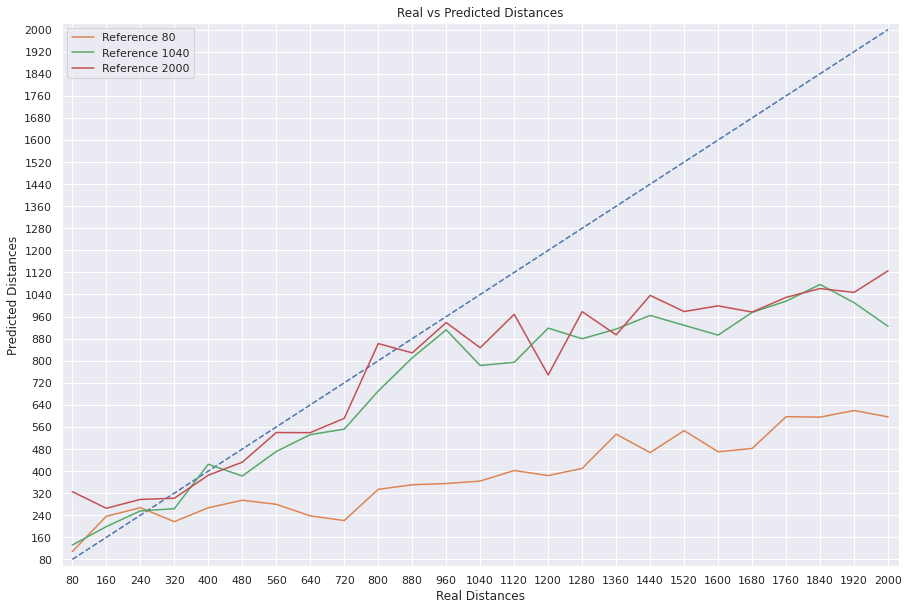

[108.55875, 236.10194, 267.4965, 216.79442, 267.15558, 294.367, 279.6416, 237.7248, 220.8444, 333.80594, 350.5385, 354.9721, 363.914, 402.16495, 383.81595, 409.65015, 533.78674, 467.01028, 546.76587, 470.0927, 482.06223, 597.23334, 595.63306, 619.5871, 596.5751]
[132.02087, 198.86575, 255.75688, 263.75577, 424.83435, 382.1834, 471.0786, 532.235, 551.98694, 690.1686, 810.4689, 911.9743, 782.791, 794.2273, 918.1833, 879.5402, 914.74347, 964.197, 928.3225, 892.85315, 975.3061, 1015.8847, 1076.4102, 1010.3401, 924.6137]
[325.54333, 265.2486, 297.33698, 301.59113, 385.0743, 432.22815, 539.6832, 539.3782, 591.22437, 862.2216, 828.5306, 938.3111, 847.01825, 968.2528, 748.4609, 977.9089, 893.8444, 1036.6553, 978.2592, 998.86194, 976.3532, 1029.6389, 1061.5123, 1047.6642, 1125.8662]
-----------------------------------------------------------------------


In [ ]:
num_of_freq_selected = 10
reference_amt = 30

# Load network
from keras.models import load_model
mm = KerasRegressor(build_fn=ann, epochs=2500, batch_size=8, verbose=0)
mm.model = load_model(path+"/Spectrum/NN/NNs/mod_bootstraped_final_new_data_NN_model_freq_10_reference_30.h5")

res = {}
reference_test = [80, 1040, 2000]
distances = [x*80 for x in range(1, 26)]

for r in reference_test:
  new_test_df = get_features(sample_freq_data_df, reference_freq_data_df, rows_testing, test_references_params=(True, r))
  #new_test_df = test_df.copy()
  
  dist_min=80 # 80
  dist_max=2000 # 2000

  Y = new_test_df.iloc[:, 0].to_numpy()
  X = new_test_df.iloc[:, 1:(new_test_df.shape[1])]

  Y_test = (Y - Y.min())/ (Y.max() - Y.min())
  X_test = (X-X.min())/ (X.max() - X.min())

  predict_test(mm, Y_test, X_test, remove_outliers=5, params_freq_reference = (10, 30), all_plots=False, epochs_num='test', training_data=False)
  # Prediction
  Y_test_pred=mm.predict(X_test)
  pred=list(Y_test_pred)
  real=list(Y_test)
  print(real)
  print(pred)

  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  
  print(real_abs)
  print(pred_abs)

  real_split ={}
  for d in distances:
    matches = [i for i in range(0,len(real_abs)) if real_abs[i]==d]
    real_split[d] = matches
  
  pred_res = []
  pred_m = []
  for d_real, matches_idx in real_split.items():
    pred_m = [pred_abs[i] for i in matches_idx]
    Q1 = np.percentile(pred_m, 25,interpolation = 'midpoint')
    Q3 = np.percentile(pred_m, 75,interpolation = 'midpoint')

    IQR = Q3 - Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR
    filtered_pred_m = []
    for v in pred_m:
      if v <= upper and v >= lower:
        filtered_pred_m.append(v)
    pred_res.append(round(np.mean(filtered_pred_m), 5))
  
  res[r] = pred_res
print('-----------------------------------------------------------------------')
print('Resuslts')

plt.figure(figsize=(15, 10))
plt.plot(distances, distances,  linestyle='--')
for re in reference_test:
  plt.plot(distances, res[re], label='Reference '+str(re))

plt.title('Real vs Predicted Distances')
plt.xlabel('Real Distances')
plt.ylabel('Predicted Distances')
plt.xlim(np.min(distances)-25, np.max(distances)+25)
plt.ylim(np.min(distances)-25, np.max(distances)+25)
plt.yticks(distances)
plt.xticks(distances)
plt.legend(loc="best")
plt.show()

for re in reference_test:
  print(res[re])

print('-----------------------------------------------------------------------')